# Thinkful 3.6.4 - Looking At Real Estate Data as a Developer  

**Goal:** Evaluate what features are important when starting new projects  
**Data:** https://www.kaggle.com/anthonypino/melbourne-housing-market  
**Proposed Model:** Lasso Regression, Elastic Net

In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
f = r'C:\Users\Abe\Google Drive\Data Science Bootcamp\Unit 3\Potpourrie\Housing\Melbourne_housing_extra_data.csv'
wf = r'C:\Users\206547663\Documents\Python Scripts\DS\Melbourne_housing_extra_data.csv'

df = pd.read_csv(wf)
df.shape

(17407, 21)

The data has many missing values. If I dropped all those rows at this point I would lose more than half of the information in the data set (Building Area = 42%) so I have to be a little smarter. Here's what I'm thinking:

1. Drop all the rows where price is NaN.
 - There really isn't much we can do to impute. Anything we could try would significantly bias the model.
2. Drop the columns for BuildingArea and YearBuilt
 - YearBuilt is not relevant for the goal because developers cannot create a house in the past.
 - There are too many missing values in order to impute without biasing the data.
3. Drop Latitude and Longitude
4. Set Bedroom2 equal to Rooms where Bedroom2 is null
 - I'd like to use Bedroom2 separately from rooms since it specifically denotes the amount of bedrooms in the house. I'd rather use an approximation like what is in Rooms than drop from ~13000 data points to 10000
5. Impute missing Bathroom and Car values by creating an average ratio for Bathrooms/Car to Bedroom2
 - These ratios have a fairly low standard deviation so this approach can be valid.
6. Fill missing CouncilArea values with the name of the council most represented in that Suburb

In [3]:
print(df.info())
print(df.notnull().sum() / df.shape[0] * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17407 entries, 0 to 17406
Data columns (total 21 columns):
Suburb           17407 non-null object
Address          17407 non-null object
Rooms            17407 non-null int64
Type             17407 non-null object
Price            13525 non-null float64
Method           17407 non-null object
SellerG          17407 non-null object
Date             17407 non-null object
Distance         17407 non-null float64
Postcode         17407 non-null int64
Bedroom2         13625 non-null float64
Bathroom         13625 non-null float64
Car              13625 non-null float64
Landsize         13603 non-null float64
BuildingArea     7323 non-null float64
YearBuilt        8429 non-null float64
CouncilArea      13601 non-null object
Lattitude        13737 non-null float64
Longtitude       13737 non-null float64
Regionname       17407 non-null object
Propertycount    17407 non-null int64
dtypes: float64(10), int64(3), object(8)
memory usage: 2.8+ MB
None

In [4]:
# Convert Date to Datetime
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Drop unecessary columns
drop_col = ['BuildingArea','YearBuilt','Lattitude','Longtitude','Address','SellerG','Postcode','Regionname']

# Drop rows where Price is missing
df.drop(drop_col,axis=1,inplace=True)
df = df[df['Price'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13525 entries, 1 to 17405
Data columns (total 13 columns):
Suburb           13525 non-null object
Rooms            13525 non-null int64
Type             13525 non-null object
Price            13525 non-null float64
Method           13525 non-null object
Date             13525 non-null datetime64[ns]
Distance         13525 non-null float64
Bedroom2         10597 non-null float64
Bathroom         10597 non-null float64
Car              10597 non-null float64
Landsize         10582 non-null float64
CouncilArea      10581 non-null object
Propertycount    13525 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 1.4+ MB


In [6]:
# Fill Bedroom 2 to value for Rooms when Bedroom2 is NA or 0
df['Bedroom2'].fillna(df['Rooms'],inplace=True)
df.loc[df['Bedroom2'] == 0, 'Bedroom2'] = df['Rooms']

# Impute values for Bathroom and Car by taking the average ratio and multiplying by bedrooms
bath_bed = (df['Bathroom'] / df['Bedroom2']).mean()
car_bed = (df['Car'] / df['Bedroom2']).mean()

df['Bathroom'].fillna(df['Bedroom2']*bath_bed,inplace=True)
df['Car'].fillna(df['Bedroom2']*car_bed,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13525 entries, 1 to 17405
Data columns (total 13 columns):
Suburb           13525 non-null object
Rooms            13525 non-null int64
Type             13525 non-null object
Price            13525 non-null float64
Method           13525 non-null object
Date             13525 non-null datetime64[ns]
Distance         13525 non-null float64
Bedroom2         13525 non-null float64
Bathroom         13525 non-null float64
Car              13525 non-null float64
Landsize         10582 non-null float64
CouncilArea      10581 non-null object
Propertycount    13525 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 2.1+ MB


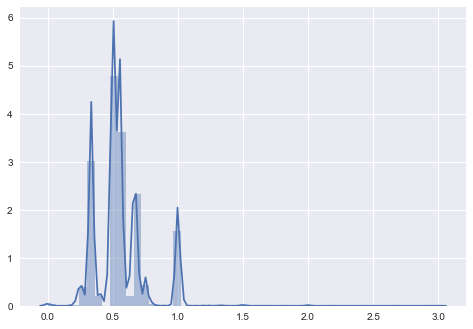

0.1943172415001489


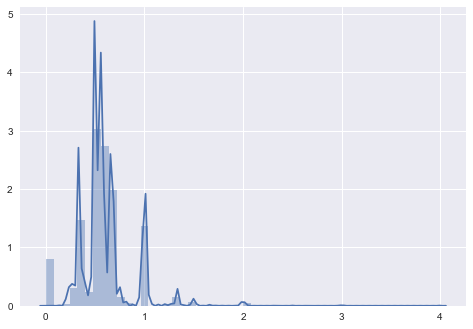

0.28931047592978526


In [7]:
# Look at standard deviation in Car and Bathroom to see if imputing method is valid

bath_ratio = df['Bathroom'] / df['Bedroom2']
car_ratio = df['Car'] / df['Bedroom2']

## Use this if there are 0s in Bedroom2
# with pd.option_context('mode.use_inf_as_null',True):
#     bath_ratio.dropna(inplace=True)

for ratio in (bath_ratio,car_ratio):
    sns.distplot(ratio)
    plt.show()
    print(ratio.std())

In [8]:
# Impute NaN Landsize by taking the average landsize per room
# IF not enough data then just use average landsize
# Drop any suburbs which have no informtion

avg_landsize_room = df.groupby(['Suburb','Rooms'])['Landsize'].transform('mean')
avg_landsize = df.groupby(['Suburb'])['Landsize'].transform('mean')

df['avg_landsize_room'] = avg_landsize_room
df['avg_landsize'] = avg_landsize

df.loc[df['avg_landsize_room'].isnull(), 'avg_landsize_room'] = df['avg_landsize']
df.loc[df['Landsize'].isnull(), 'Landsize'] = df['avg_landsize_room']

df = df[df['Landsize'].notnull()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13501 entries, 1 to 17405
Data columns (total 15 columns):
Suburb               13501 non-null object
Rooms                13501 non-null int64
Type                 13501 non-null object
Price                13501 non-null float64
Method               13501 non-null object
Date                 13501 non-null datetime64[ns]
Distance             13501 non-null float64
Bedroom2             13501 non-null float64
Bathroom             13501 non-null float64
Car                  13501 non-null float64
Landsize             13501 non-null float64
CouncilArea          10581 non-null object
Propertycount        13501 non-null int64
avg_landsize_room    13501 non-null float64
avg_landsize         13501 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(4)
memory usage: 1.6+ MB


In [9]:
# Impute values for Council Area by using the same council name for the same suburb name

def fill_council(x):
    y = x.dropna().mode()
    if len(y) > 1:
        print(x)
        raise ValueError
    elif len(y) < 1:
        return np.nan
    else:
        return y[0]
    
df['imputed_council'] = df.groupby(['Suburb'])['CouncilArea'].transform(fill_council)
df.loc[df['CouncilArea'].isnull(),'CouncilArea'] = df['imputed_council']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13501 entries, 1 to 17405
Data columns (total 16 columns):
Suburb               13501 non-null object
Rooms                13501 non-null int64
Type                 13501 non-null object
Price                13501 non-null float64
Method               13501 non-null object
Date                 13501 non-null datetime64[ns]
Distance             13501 non-null float64
Bedroom2             13501 non-null float64
Bathroom             13501 non-null float64
Car                  13501 non-null float64
Landsize             13501 non-null float64
CouncilArea          13501 non-null object
Propertycount        13501 non-null int64
avg_landsize_room    13501 non-null float64
avg_landsize         13501 non-null float64
imputed_council      13501 non-null object
dtypes: datetime64[ns](1), float64(8), int64(2), object(5)
memory usage: 2.4+ MB


In [10]:
# Drop the columns we created to impute missing values

drop_col = ['avg_landsize_room','imputed_council','avg_landsize']
df.drop(drop_col,axis=1,inplace=True)

Now that we have a clean set of data we can take a look at summary visuals with a heatmap and a pairgrid

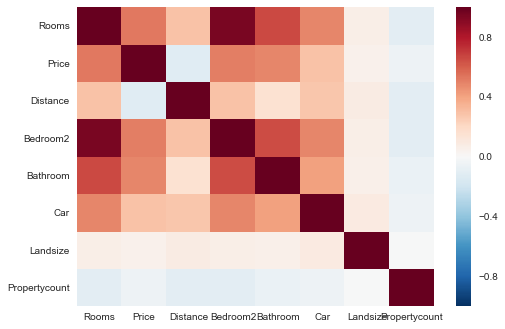

In [11]:
# Heatmap
sns.heatmap(df.corr())
plt.show()

C:\Users\206547663\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


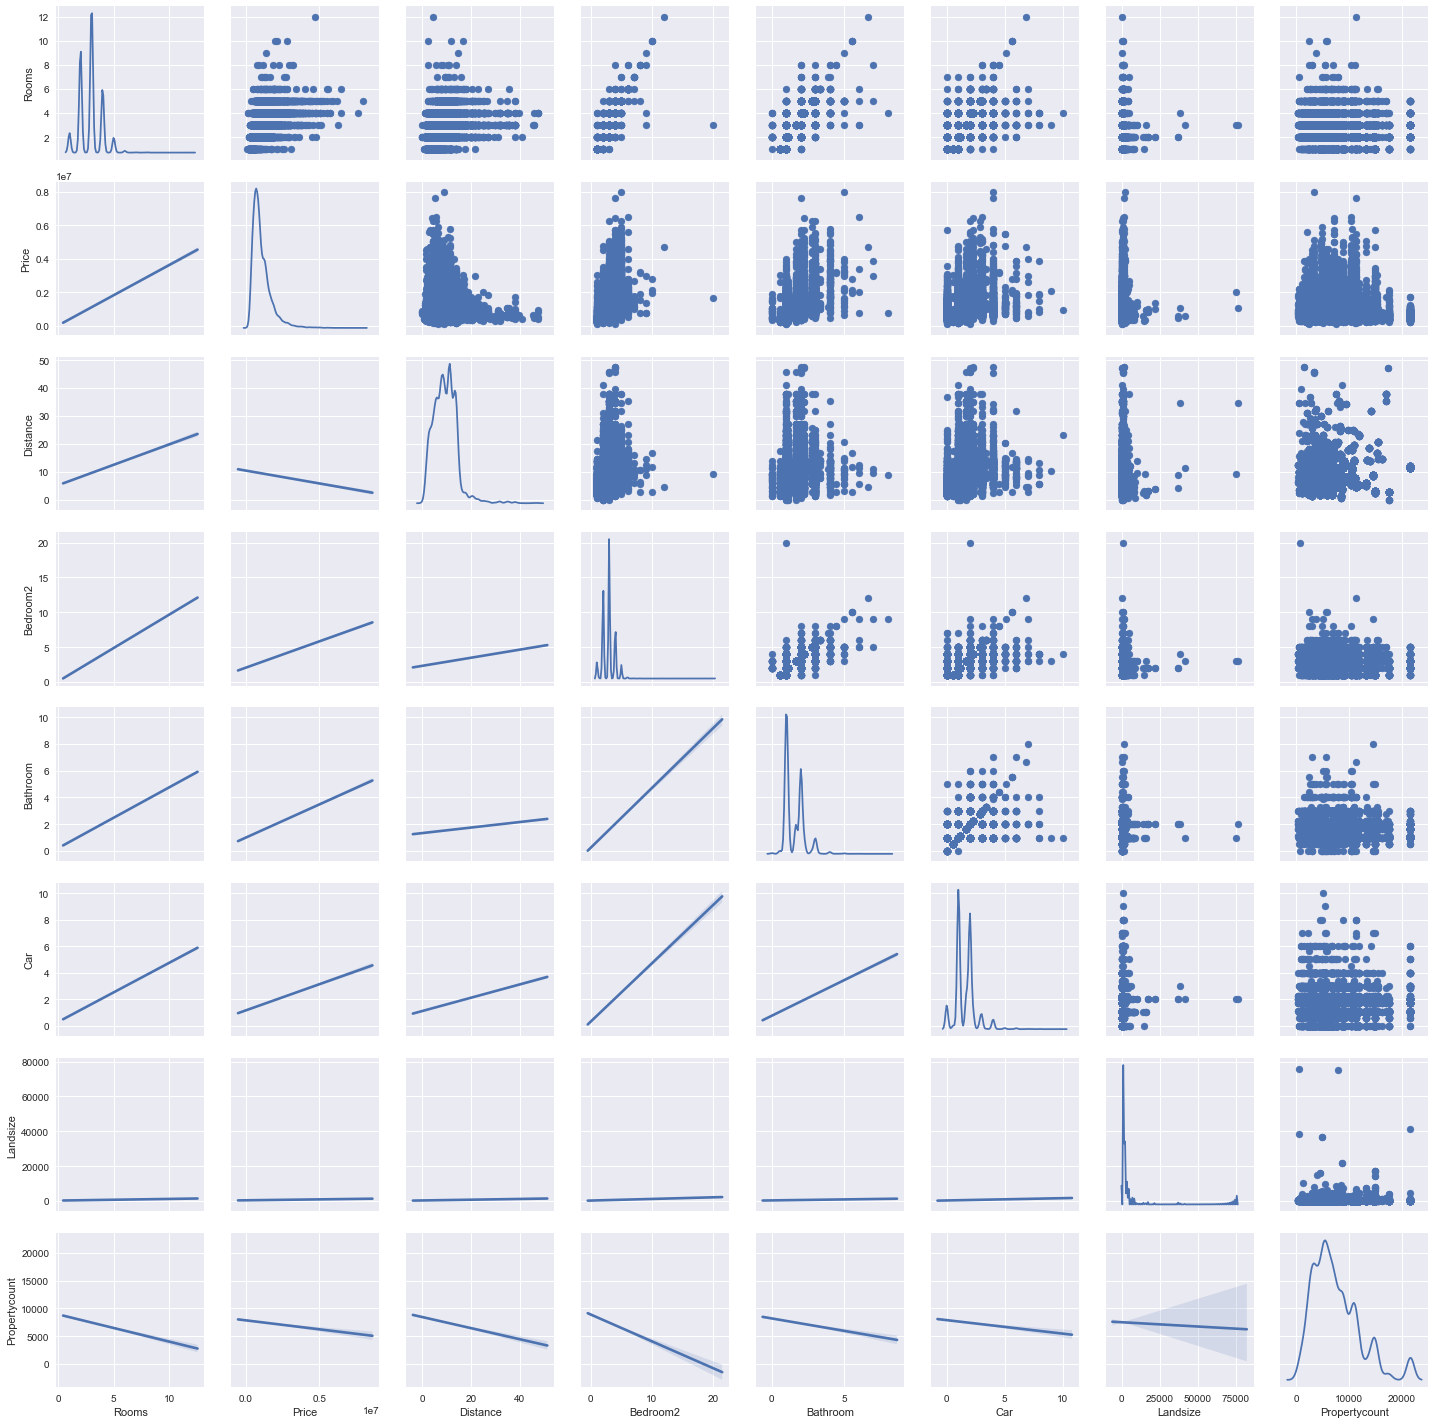

In [12]:
g = sns.PairGrid(df.loc[:,df.columns !='Date'], diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0)) 
g.map_diag(sns.kdeplot)

plt.show()

Reviewing the charts above it looks like Landsize has some very big outliers. After taking a closer look, there seems to be a few extremely large values that may distract the model. I will go ahead and remove them.  

There are also some rows where landsize is equal to 0. Intuitively this does not make sense. I will replace these values by using the median ratio for Landsize to Bedroom2.

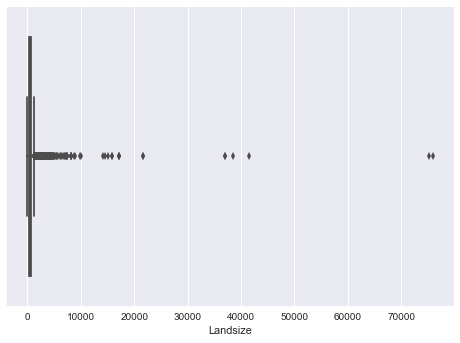

count    13501.000000
mean       500.788316
std       1320.556443
min          0.000000
25%        192.000000
50%        438.000000
75%        626.750000
max      76000.000000
Name: Landsize, dtype: float64

In [13]:
# Look at the outliers

sns.boxplot(df['Landsize'])
plt.show()
df['Landsize'].describe()

Amount of data lost by removing outliers: 0.019998518628249758


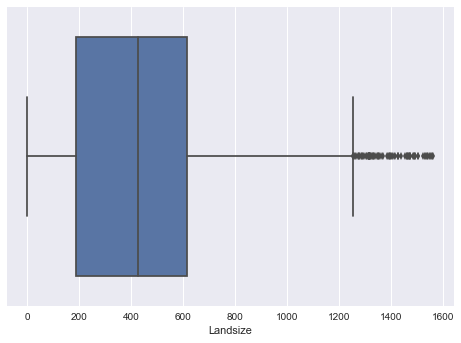

In [14]:
# Remove the outliers
q = df['Landsize'].quantile(.98)

print('Amount of data lost by removing outliers: {}'.format((df['Landsize'] > q).sum() / df.shape[0]))
df = df.loc[df['Landsize'] < q,:]

sns.boxplot(df['Landsize'])
plt.show()

1790


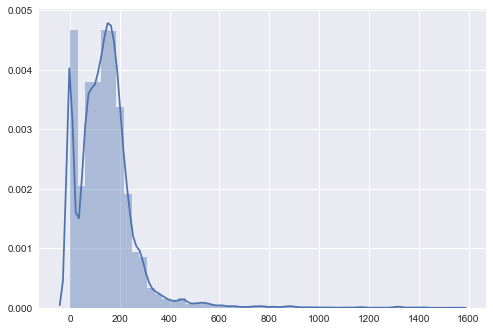

In [15]:
# Fix where landsize is equal to 0

print(df.loc[df['Landsize'] == 0,'Bedroom2'].count())

sns.distplot((df['Landsize'] / df['Bedroom2']))
plt.show()

In [16]:
# Replace Landsize values to the median landsize to bedroom ratio * amount of bedrooms

landsize_ratio = (df['Landsize'] / df['Bedroom2']).median()
df['Landsize'].replace(0,df['Bedroom2']*landsize_ratio,inplace=True)

I will take a closer look at categorical variables and their variance by looking at their barplots. Judging by their plots, they all look like their values have a significant affect on price.

In [17]:
categorical = df.select_dtypes(include=['object'])

for category in categorical:
    column = df[category]
    print ('{}: {}'.format(category, column.nunique()))
    if column.nunique() < 50:
        print(column.unique())

Suburb: 282
Type: 3
['h' 't' 'u']
Method: 5
['S' 'SP' 'PI' 'VB' 'SA']
CouncilArea: 32
['Yarra' 'Moonee Valley' 'Port Phillip' 'Darebin' 'Hobsons Bay'
 'Stonnington' 'Boroondara' 'Monash' 'Glen Eira' 'Whitehorse' 'Maribyrnong'
 'Bayside' 'Moreland' 'Manningham' 'Banyule' 'Melbourne' 'Kingston'
 'Brimbank' 'Hume' 'Knox' 'Maroondah' 'Casey' 'Melton' 'Greater Dandenong'
 'Nillumbik' 'Whittlesea' 'Frankston' 'Macedon Ranges' 'Yarra Ranges'
 'Wyndham' 'Cardinia' 'Unavailable']


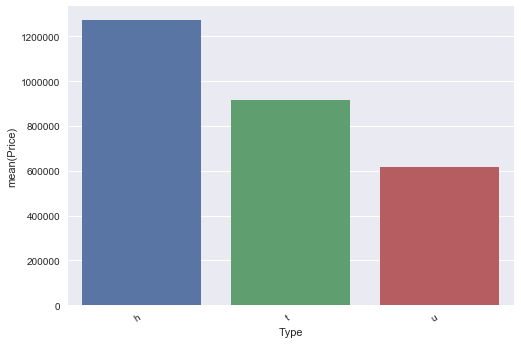

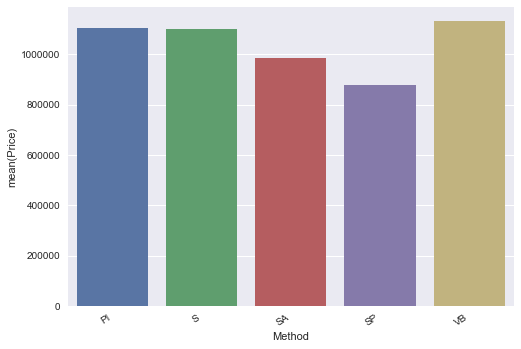

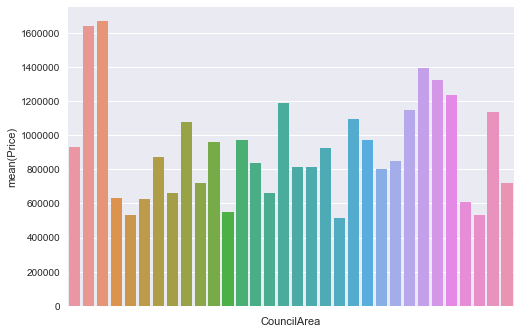

In [18]:
# Visually inspect variance between categorical variables

for category in categorical:
    column = df[category]
    if column.nunique() < 10:
        df_ss = df.groupby(column).mean()
        ax = sns.barplot(x=df_ss.index,y=df_ss['Price'])
        plt.xticks(rotation=33, horizontalalignment='right')
        plt.show()
    elif column.nunique() < 50:
        df_ss = df.groupby(column).mean()
        ax = sns.barplot(x=df_ss.index,y=df_ss['Price'])
        ax.set(xticklabels=[])
        plt.show()

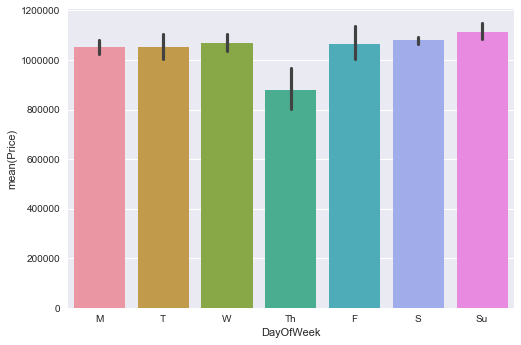

In [19]:
# Dive into differences in properties sold by day of week
df['DayOfWeek'] = df['Date'].dt.dayofweek

days = ['M','T','W','Th','F','S','Su']
df['DayOfWeek'].replace(range(0,7,1),days,inplace=True)

sns.barplot(x=df['DayOfWeek'],y=df['Price'], order=days)
plt.show()

In [20]:
# Drop Date for modelling purposes
df.drop('Date',axis=1,inplace=True)

# The Model

I want to use Lasso regression. Regression, because it gives the clearest interpretation of the features in the model. There are 347 features after getting dummies. Lasso will be able to remove features which are not useful so we can focus on the most important ones. I'll compare it with Elastic Net which blends Lasso and Ridge regression as a comparison.   

I'll start by creating some features that I as a developer have control over and might be interested:

- Bedroom to Land Ratio
- Bathroom to Bedroom Ratio
- Ratio of available houses to total houses per suburb
- Non bedroom and bathroom rooms in a building

In [25]:
df_dum = pd.get_dummies(df)

# Create some new columns
df_dum['BedroomLandRatio'] = df['Bedroom2'] / df['Landsize']
df_dum['BathBedRatio'] = df['Bathroom'] / df['Bedroom2']
df_dum['AvailableRatio'] = df.groupby('Suburb')['Suburb'].transform('count') / df['Propertycount']
df_dum['OtherRooms'] = df['Rooms'] - (df['Bedroom2'] + df['Bathroom'])
df_dum.loc[df_dum['OtherRooms'] < 0,'OtherRooms'] == 0

X = df_dum.loc[:,df_dum.columns != 'Price']
y = df_dum['Price']

In [26]:
X.shape

(13230, 340)

In [27]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

In [27]:
# Use gridsearch in the future for parameter tuning

for num in range(1,6,1):
    lasso = Lasso(alpha=num, max_iter=1000, tol=.1)
    scores = cross_val_score(lasso, X, y)
    print(num)
    print(scores)
    print(scores.mean())

In [28]:
for num in range(1,6,1):
    enet = ElasticNet(alpha=num, l1_ratio=.75)
    scores = cross_val_score(enet, X, y)
    print(num)
    print(scores)
    print(scores.mean())

1
[ 0.51449868  0.45843635  0.44272178]
0.471885600628
2
[ 0.47237681  0.41620731  0.41170027]
0.433428128952
3
[ 0.44695298  0.38938824  0.39421325]
0.410184824487
4
[ 0.42756068  0.36849691  0.38068797]
0.392248518727
5
[ 0.41138504  0.35091961  0.36887286]
0.377059170175


In [29]:
# Final model to use to get the coeffecients

lasso = Lasso(alpha=2)

lasso.fit(X,y)
coef = lasso.coef_
lasso.score(X,y)

C:\Users\206547663\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.69179219971955996

In [30]:
# Create dataframe for the coefficients
col_list = list(X.columns)
df_coef = pd.DataFrame(col_list)
df_coef.loc[0] = 'Intercept'
df_coef['Coef'] = coef
df_coef.sort_values('Coef',ascending=False,inplace=True)

# Group the take the absolute value of the coefficients group and average them to get an idea of their effect
df_coef['Category']  = df_coef[0].apply(lambda x: x.split('_')[0])
df_coef['Abs_Coef'] = df_coef['Coef'].abs()
gbo = df_coef.groupby('Category')

def absolute_mean(series):
    np.mean(series.abs())

gbo.mean().sort_values('Abs_Coef',ascending=False)

,Coef,Abs_Coef
Category,,
Bathroom,358090.572839,358090.572839
BathBedRatio,-299166.174530,299166.174530
Type,167547.714627,216790.643823
Suburb,26624.284128,178518.611921
CouncilArea,-45004.543403,147304.245320
OtherRooms,87605.689836,87605.689836
Bedroom2,61728.821829,61728.821829
Intercept,41572.336036,41572.336036
Car,40674.411461,40674.411461


It looks like the amount of bathrooms in a house has the greatest affect on the value of a building. I think its strange how strong the effect is so I will investigate further by looking at the distribution of price accross the different values for bathroom. I will also look at Bedroom2 as well. 

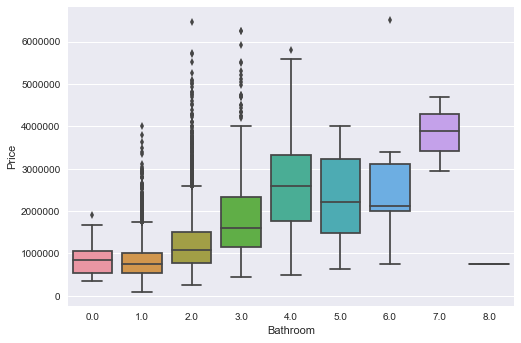

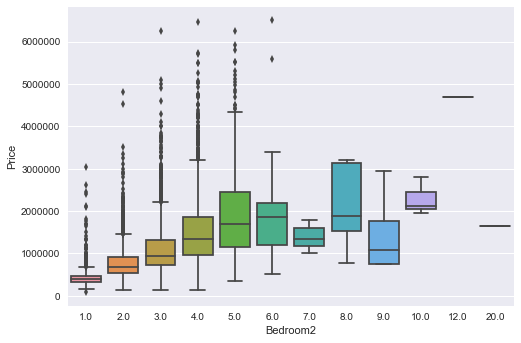

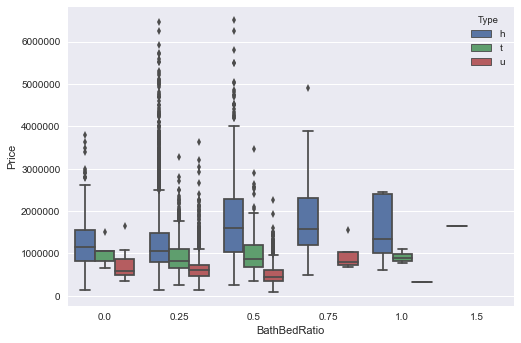

In [38]:
sns.boxplot(x=df['Bathroom'].round(0),y=df['Price'])
plt.show()

sns.boxplot(x=df['Bedroom2'].round(0),y=df['Price'])
plt.show()


def myround(number):
    return round(number * 2) / 4

sns.boxplot(x=df_dum['BathBedRatio'].map(myround),y=df_dum['Price'], data=df_dum, hue=df['Type'])
plt.show()

The bath to bed ratio might not be the best ratio to look at while looking at the whole data set because it doesn't take into account the type of the building. Looking at the boxplots above, we can see that the change in the bath to bed ratio affects each type of building differently.

It looks like there might be some outliers in Bedroom2. Some of these look to be values I imputed by copying what was in the Rooms column. I will re-run the model without the outliers to see if there are any significant changes.

In [41]:
df.loc[df['Bedroom2'] > 5].shape[0]

75

In [42]:
# Rerun model with outliers removed

df_dum = df_dum.loc[df_dum['Bedroom2'] < 5]
X = df_dum.loc[:,df_dum.columns != 'Price']
y = df_dum['Price']

lasso.fit(X,y)
coef = lasso.coef_
lasso.score(X,y)

col_list = list(X.columns)

df_coef = pd.DataFrame(col_list)
df_coef.loc[0] = 'Intercept'
df_coef['Coef'] = coef
df_coef.sort_values('Coef',ascending=False,inplace=True)

df_coef['Category']  = df_coef[0].apply(lambda x: x.split('_')[0])
df_coef['Abs_Coef'] = df_coef['Coef'].abs()
gbo = df_coef.groupby('Category')

def absolute_mean(series):
    np.mean(series.abs())

gbo.mean().sort_values('Abs_Coef',ascending=False)

C:\Users\206547663\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Coef,Abs_Coef
Category,,
Bathroom,307885.147330,307885.147330
BathBedRatio,-228457.014891,228457.014891
Type,161924.559171,206434.473956
Suburb,25219.936848,173497.014737
CouncilArea,-48156.549567,152901.843668
Bedroom2,71732.091650,71732.091650
Intercept,65587.395506,65587.395506
OtherRooms,61755.540161,61755.540161
Car,39506.163866,39506.163866


Looks like we were able to shrink our coefficients and get better estimates of each feature.

## Conclusion

According to our model, bathrooms are the most important feature to consider when developing a residential building. I would further explore this by running seperate models for each type of building to see if that changes its importance. 